This notebook processes the data involved with the multi-objective experiments.
It requires a working installation of Python with pandas, and RPy2; alongside R with ggplot.

# Specification
These are basically the parameters that differ from problem to problem for the data processing,
placed on top for easy access. Ensure that the filenames below are correct!

In [1]:
problem_name = "bot_vs_maxcut"
path_data_hypervolume = "paper_multiobjective_9c2eeca_bot_vs_maxcut_hv.csv.gz"
path_data_archives = "2021-12-20-paper_multiobjective_9c2eeca_archives.zip"
path_data_references = "reference_fronts.zip"
columns_configuration = ["approach", "l", "fns"]
columns_run = columns_configuration + ["run"]

approach_relabeling = {
    "0--c0": "Objective / Domination",
    "0_-1--c8--x-1": "Asymmetric Kernel / Domination",
    "0_-1--c9--x-1": "Symmetric Kernel / Domination",
    "-3_-1--c0": "Objective / Scalarized",
    "-3_-1--c8--x-1": "Asymmetric Kernel / Scalarized",
    "-3_-1--c9--x-1": "Symmetric Kernel / Scalarized",
}

preferred_ordering = [
    "Objective / Domination",
    "Objective / Scalarized",
    "Asymmetric Kernel / Domination",
    "Asymmetric Kernel / Scalarized",
    "Symmetric Kernel / Domination",
    "Symmetric Kernel / Scalarized",
]
preferred_ordering_front = preferred_ordering + ["Best Known"]

def run_to_elitist_archive(df):
    return "paper_multiobjective_9c2eeca_bot_vs_maxcut/approach_" + df["approach spec"].map(str) + "__run_" + df["run"].map(str) + "__l_" + df["l"].map(str) + "__fns_" + df["fns"].map(str) + "/elitist_archive.dat"

def run_to_reference_front(df):
    return "bot_maxcut/l_" + df["l"].map(str) + "__fns_" + df["fns"].map(str) + "__s_0__k_5.txt"

# Imports

In [2]:
import pandas as pd
import numpy as np
import zipfile

%load_ext rpy2.ipython
%Rdevice svg

C:\Program Files\Python310\lib\site-packages\rpy2\robjects\packages.py:366: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [3]:
%%R
library(ggplot2)
library(scales)

# tables & data processing in R
library(gt)
library(xtable)
library(dplyr)
library(tidyr)

R[write to console]: 
Attaching package: 'dplyr'


R[write to console]: The following objects are masked from 'package:stats':

    filter, lag


R[write to console]: The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




# Loading Data
This data is required for both plots.

- It is the data used for the convergence plots
- It is used to determine the median run (i.e., the front that will be plotted)

In [4]:
# Load hypervolume data
data_hypervolume = pd.read_csv(path_data_hypervolume)
data_hypervolume["approach spec"] = data_hypervolume["approach"]
data_hypervolume["approach"] = data_hypervolume["approach"].replace(approach_relabeling)
data_hypervolume

,#evaluations,time (ms),hypervolume,approach,run,l,fns,approach spec
0,8158,35,0.700285,Objective / Domination,0,50,1,0--c0
1,19935,78,0.749810,Objective / Domination,0,50,1,0--c0
2,29249,114,0.802837,Objective / Domination,0,50,1,0--c0
3,36451,140,0.820427,Objective / Domination,0,50,1,0--c0
4,49850,180,0.824846,Objective / Domination,0,50,1,0--c0
...,...,...,...,...,...,...,...,...
192839,96289,687,0.949566,Objective / Scalarized,0,25,8,-3_-1--c0
192840,222820,1407,0.998541,Objective / Scalarized,0,25,8,-3_-1--c0
192841,5211418,27649,0.998541,Objective / Scalarized,0,25,8,-3_-1--c0
192842,14292481,73708,0.998541,Objective / Scalarized,0,25,8,-3_-1--c0


# Plotting: Convergence Graphs

In [5]:
# Specifications for resampling
max_evaluations = 100_000_000
sample_every = 1_000_000

# Precompute bin each sample ends up in
data_resampled_hypervolume = data_hypervolume.copy()
data_resampled_hypervolume["#evaluations bin"] = (data_resampled_hypervolume["#evaluations"] / sample_every).apply(np.ceil) * sample_every

# Precompute the bins
l_bins = pd.DataFrame({"#evaluations bin": range(sample_every, max_evaluations + sample_every, sample_every)})

# Perform resampling per run
def resample_run(run_df):
    best_per_bin = run_df.groupby("#evaluations bin")["hypervolume"].max().reset_index()
    gap_filled   = l_bins.merge(best_per_bin, left_on="#evaluations bin", right_on="#evaluations bin", how="left").ffill()
    return gap_filled

data_resampled_hypervolume = data_resampled_hypervolume.groupby(columns_run).apply(resample_run).reset_index()

# Compute q05, q50 (median) and q95 per bin
data_quantiles_hypervolume = data_resampled_hypervolume.groupby(columns_configuration + ["#evaluations bin"])["hypervolume"].quantile([0.05, 0.5, 0.95]).unstack().reset_index()

# Convert to 1 - Hypervolume (such that a log plot can be used)
data_quantiles_hypervolume["Q_0.05(1 - HV)"] = 1 - data_quantiles_hypervolume[0.05]
data_quantiles_hypervolume["Q_0.5(1 - HV)"] = 1 - data_quantiles_hypervolume[0.5]
data_quantiles_hypervolume["Q_0.95(1 - HV)"] = 1 - data_quantiles_hypervolume[0.95]

data_quantiles_hypervolume

,approach,l,fns,#evaluations bin,0.05,0.5,0.95,Q_0.05(1 - HV),Q_0.5(1 - HV),Q_0.95(1 - HV)
0,Asymmetric Kernel / Domination,12,1,1000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
1,Asymmetric Kernel / Domination,12,1,2000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
2,Asymmetric Kernel / Domination,12,1,3000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
3,Asymmetric Kernel / Domination,12,1,4000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
4,Asymmetric Kernel / Domination,12,1,5000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
9595,Symmetric Kernel / Scalarized,100,8,96000000,0.986059,0.998184,0.999285,0.013941,0.001816,0.000715
9596,Symmetric Kernel / Scalarized,100,8,97000000,0.986059,0.998184,0.999285,0.013941,0.001816,0.000715
9597,Symmetric Kernel / Scalarized,100,8,98000000,0.986059,0.998184,0.999285,0.013941,0.001816,0.000715
9598,Symmetric Kernel / Scalarized,100,8,99000000,0.986059,0.998184,0.999285,0.013941,0.001816,0.000715


In [6]:
# Some extra annotation to allow subsampling of number of points
# Otherwise the graph gets somewhat messy
number_of_points = 10
divisor = (max_evaluations - sample_every) / number_of_points

divided = data_quantiles_hypervolume["#evaluations bin"] // divisor
data_quantiles_hypervolume["show point"] = (divided != divided.shift(1)).fillna(True)

In [7]:
# Filter out smaller
data_quantiles_hypervolume_f = data_quantiles_hypervolume[data_quantiles_hypervolume["l"] > 25]

R[write to console]: Saving 15 x 3.5 in image



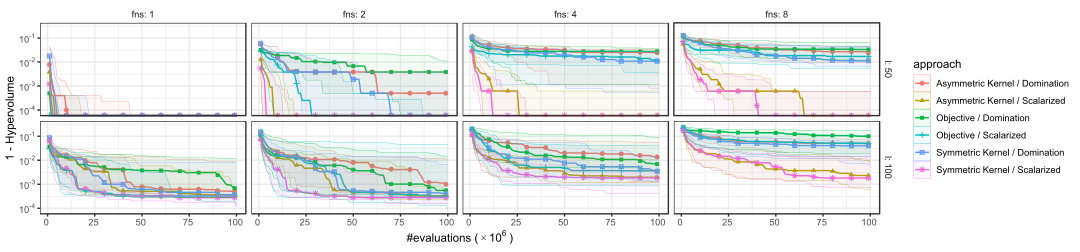

In [8]:
%%R -i problem_name -i data_quantiles_hypervolume_f -w 15 -h 3.5

plt <- ggplot(data_quantiles_hypervolume_f,
              aes(
                  x=`#evaluations bin`,
                  ymin=`Q_0.95(1 - HV)`,
                  y=`Q_0.5(1 - HV)`,
                  ymax=`Q_0.05(1 - HV)`,
                  color=`approach`,
                  fill=`approach`,
                  shape=`approach`)
              ) +
    geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
    geom_line() +
    geom_ribbon(alpha = 0.05, size=0.1) +
    scale_y_log10(
        breaks = trans_breaks("log10", function(x) 10^x),
        labels = trans_format("log10", math_format(10^.x))
    ) +
    scale_x_continuous(
        labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
    ) +
    labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume") +
    facet_grid(l ~ fns, label=label_both) +
    theme_bw() +
    theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_convergence_multiple_l.pdf", sep=""), device=cairo_pdf)

plt

Go down to $l = 100$, in order to avoid taking up too much space.

In [9]:
data_quantiles_hypervolume_f = data_quantiles_hypervolume[data_quantiles_hypervolume["l"] == 100]

R[write to console]: Saving 15 x 3.5 in image



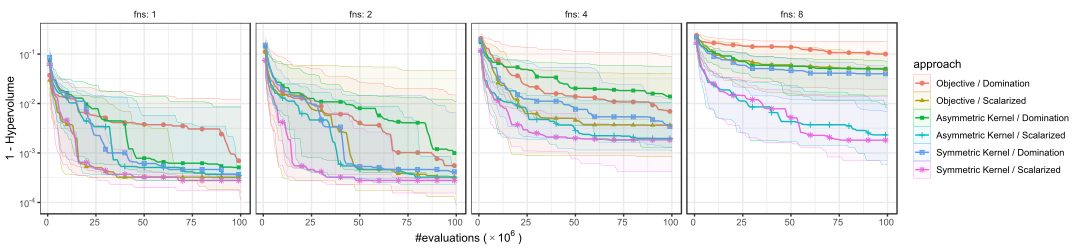

In [10]:
%%R -i preferred_ordering -i problem_name -i data_quantiles_hypervolume_f -w 15 -h 3.5
data_quantiles_hypervolume_f$approach = factor(data_quantiles_hypervolume_f$approach, levels=preferred_ordering)

plt <- ggplot(data_quantiles_hypervolume_f,
              aes(
                x=`#evaluations bin`,
                ymin=`Q_0.95(1 - HV)`,
                y=`Q_0.5(1 - HV)`,
                ymax=`Q_0.05(1 - HV)`,
                color=`approach`,
                fill=`approach`,
                shape=`approach`)
) +
geom_point(aes(alpha=`show point`)) + scale_alpha_identity(guide="none") +
geom_line() +
geom_ribbon(alpha = 0.05, size=0.1) +
scale_y_log10(
    breaks = trans_breaks("log10", function(x) 10^x),
labels = trans_format("log10", math_format(10^.x))
) +
scale_x_continuous(
    labels = unit_format(unit = "", scale = 1 / 1e+06, digits = 2)
) +
labs(x =  expression("#evaluations (" %*% 10^6 ~ ")"), y = "1 - Hypervolume") +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_convergence_l100.pdf", sep=""), device=cairo_pdf)

plt

# Plotting: Fronts
## Median run

In [7]:
# Determine which run is the median run for a configuration as representative of the final front.
# 1: determine the final hypervolume as we'll be plotting the final archive.
data_last_hypervolume = data_hypervolume.sort_values("#evaluations").groupby(columns_run).last().reset_index()
# 2: From this determine median hypervolume
data_last_hypervolume = data_last_hypervolume.merge(data_last_hypervolume.groupby(columns_configuration)["hypervolume"].median().rename("median hypervolume").reset_index())
data_last_hypervolume["d hv mhv"] = (data_last_hypervolume["hypervolume"] - data_last_hypervolume["median hypervolume"]).abs()
# 3: Find the nearest sample
data_last_hypervolume["archive path"] = run_to_elitist_archive(data_last_hypervolume)
data_last_hypervolume["reference path"] = run_to_reference_front(data_last_hypervolume)

In [8]:
data_run_median_hv = data_last_hypervolume.groupby(columns_configuration).apply(lambda df: df.iloc[df["d hv mhv"].argmin()]).reset_index(drop=True)
data_run_median_hv

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path
0,Asymmetric Kernel / Domination,12,1,0,4372,11,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_1__s_0__k_5.txt
1,Asymmetric Kernel / Domination,12,2,0,2070,7,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_2__s_0__k_5.txt
2,Asymmetric Kernel / Domination,12,4,0,3718,9,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_4__s_0__k_5.txt
3,Asymmetric Kernel / Domination,12,8,0,16238,60,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_8__s_0__k_5.txt
4,Asymmetric Kernel / Domination,25,1,0,19703954,1665466,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_25__fns_1__s_0__k_5.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Symmetric Kernel / Scalarized,50,8,0,39946666,1983348,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_50__fns_8__s_0__k_5.txt
92,Symmetric Kernel / Scalarized,100,1,0,98483415,10328755,0.999722,-3_-1--c9--x-1,0.999722,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_1__s_0__k_5.txt
93,Symmetric Kernel / Scalarized,100,2,0,50811187,3696534,0.999722,-3_-1--c9--x-1,0.999722,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_2__s_0__k_5.txt
94,Symmetric Kernel / Scalarized,100,4,5,45791291,3287699,0.998109,-3_-1--c9--x-1,0.998155,0.000046,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_4__s_0__k_5.txt


In [9]:
# Load archives from zip
archives_zip = zipfile.ZipFile(path_data_archives)

def load_archives_from_zip(path):
    with archives_zip.open(path) as f:
        df = pd.read_csv(f)
        df["archive path"] = path
        return df

archives_zip_df = pd.concat([
    load_archives_from_zip(archive_path)
    for archive_path in data_run_median_hv["archive path"]
])
archives_zip_df

,objective0,objective1,constraint,solution,best_traps,archive path
0,5,122,0,11011010100,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
1,9,118,0,11011000110,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
2,10,116,0,110100111000,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
3,12,112,0,110110001010,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
4,7,120,0,11001110100,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
...,...,...,...,...,...,...
46,81,7867,0,0100001110111101101110111011111011111001001010...,"6,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
47,40,8008,0,0000100111111001111110011101011001110001100011...,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
48,43,8006,0,1111010000000010001001110010000110001110011100...,"6,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
49,51,7998,0,0000100111111101110110011001111001010001100011...,"7,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...


In [10]:
approaches_chosen_archives_df = data_last_hypervolume.merge(archives_zip_df, on="archive path")[["objective0", "objective1"] + columns_run]
approaches_chosen_archives_df

,objective0,objective1,approach,l,fns,run
0,5,122,Asymmetric Kernel / Domination,12,1,0
1,9,118,Asymmetric Kernel / Domination,12,1,0
2,10,116,Asymmetric Kernel / Domination,12,1,0
3,12,112,Asymmetric Kernel / Domination,12,1,0
4,7,120,Asymmetric Kernel / Domination,12,1,0
...,...,...,...,...,...,...
2193,81,7867,Symmetric Kernel / Scalarized,100,8,6
2194,40,8008,Symmetric Kernel / Scalarized,100,8,6
2195,43,8006,Symmetric Kernel / Scalarized,100,8,6
2196,51,7998,Symmetric Kernel / Scalarized,100,8,6


In [11]:
# Load relevant reference fronts from zip
reference_fronts_zip = zipfile.ZipFile(path_data_references)

def load_reference_front_from_zip(path):
    with reference_fronts_zip.open(path) as f:
        df = pd.read_csv(f, sep=" ", header=None, skiprows=2)
        df["reference path"] = path
        return df

reference_fronts_df = pd.concat([
    load_reference_front_from_zip(reference_path)
    for reference_path in data_last_hypervolume["reference path"].unique()
])

# Rename to bring the definition in line with the other dataframe
reference_fronts_df = reference_fronts_df.rename(columns={0: "objective0", 1: "objective1"})

reference_fronts_df

,objective0,objective1,reference path
0,12,112,bot_maxcut/l_12__fns_1__s_0__k_5.txt
1,10,116,bot_maxcut/l_12__fns_1__s_0__k_5.txt
2,9,118,bot_maxcut/l_12__fns_1__s_0__k_5.txt
3,7,120,bot_maxcut/l_12__fns_1__s_0__k_5.txt
4,5,122,bot_maxcut/l_12__fns_1__s_0__k_5.txt
...,...,...,...
46,49,8001,bot_maxcut/l_100__fns_8__s_0__k_5.txt
47,47,8003,bot_maxcut/l_100__fns_8__s_0__k_5.txt
48,44,8004,bot_maxcut/l_100__fns_8__s_0__k_5.txt
49,43,8006,bot_maxcut/l_100__fns_8__s_0__k_5.txt


In [12]:
reference_approach_df = reference_fronts_df.merge(data_run_median_hv, on="reference path")[["objective0", "objective1"] + [c for c in columns_configuration if c != "approach" ]].drop_duplicates()
reference_approach_df["approach"] = "Best Known"
reference_approach_df["run"] = np.nan
reference_approach_df

,objective0,objective1,l,fns,approach,run
0,12,112,12,1,Best Known,NaN
6,10,116,12,1,Best Known,NaN
12,9,118,12,1,Best Known,NaN
18,7,120,12,1,Best Known,NaN
24,5,122,12,1,Best Known,NaN
...,...,...,...,...,...,...
2208,49,8001,100,8,Best Known,NaN
2214,47,8003,100,8,Best Known,NaN
2220,44,8004,100,8,Best Known,NaN
2226,43,8006,100,8,Best Known,NaN


In [17]:
fronts_df = pd.concat([approaches_chosen_archives_df, reference_approach_df])

In [18]:
fronts_df_f = fronts_df[fronts_df["l"] == 100]

R[write to console]: Saving 15 x 3.5 in image



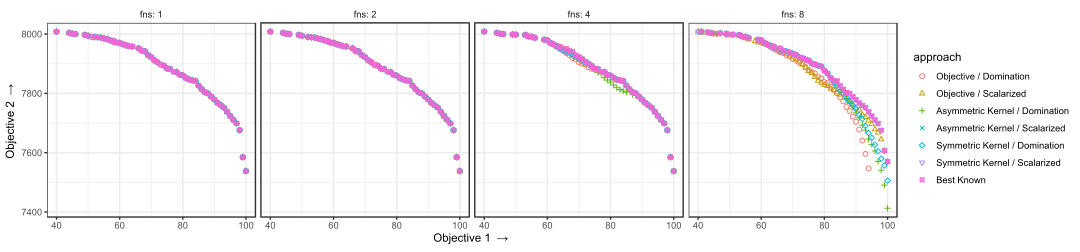

In [19]:
%%R -i preferred_ordering_front -i problem_name -i fronts_df_f -w 15 -h 3.5

fronts_df_f$approach = factor(fronts_df_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_df_f,
              aes(
                  x=`objective0`,
                  y=`objective1`,
                  color=`approach`,
                  shape=`approach`),
              fill=NA,
) +
geom_point() +
scale_shape_manual(values=1:length(preferred_ordering_front)) +
labs(x = expression("Objective 1 " %->% ""), y = expression("Objective 2 " %->% "")) +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_final_front_l100.pdf", sep=""), device=cairo_pdf)

plt

## Best run
As we had some cases where the front was better than reference, also plotting the best run might be of interest.
Note that these cells do not reload the reference front: they are assumed to have been loaded by the previous cells,
and be identical.

In [20]:
data_run_max_hv = data_last_hypervolume.groupby(columns_configuration).apply(lambda df: df.iloc[df["hypervolume"].argmax()]).reset_index(drop=True)
data_run_max_hv

,approach,l,fns,run,#evaluations,time (ms),hypervolume,approach spec,median hypervolume,d hv mhv,archive path,reference path
0,Asymmetric Kernel / Domination,12,1,0,4372,11,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_1__s_0__k_5.txt
1,Asymmetric Kernel / Domination,12,2,0,2070,7,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_2__s_0__k_5.txt
2,Asymmetric Kernel / Domination,12,4,0,3718,9,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_4__s_0__k_5.txt
3,Asymmetric Kernel / Domination,12,8,0,16238,60,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_12__fns_8__s_0__k_5.txt
4,Asymmetric Kernel / Domination,25,1,0,19703954,1665466,1.000000,0_-1--c8--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_25__fns_1__s_0__k_5.txt
...,...,...,...,...,...,...,...,...,...,...,...,...
91,Symmetric Kernel / Scalarized,50,8,0,39946666,1983348,1.000000,-3_-1--c9--x-1,1.000000,0.000000,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_50__fns_8__s_0__k_5.txt
92,Symmetric Kernel / Scalarized,100,1,2,66226229,5370633,0.999907,-3_-1--c9--x-1,0.999722,0.000185,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_1__s_0__k_5.txt
93,Symmetric Kernel / Scalarized,100,2,4,51765309,3755285,0.999907,-3_-1--c9--x-1,0.999722,0.000185,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_2__s_0__k_5.txt
94,Symmetric Kernel / Scalarized,100,4,19,73752414,5957066,0.999631,-3_-1--c9--x-1,0.998155,0.001476,paper_multiobjective_9c2eeca_bot_vs_maxcut/app...,bot_maxcut/l_100__fns_4__s_0__k_5.txt


In [21]:
# Load archives from zip
archives_zip = zipfile.ZipFile(path_data_archives)

def load_archives_from_zip(path):
    with archives_zip.open(path) as f:
        df = pd.read_csv(f)
        df["archive path"] = path
        return df

archives_best_zip_df = pd.concat([
    load_archives_from_zip(archive_path)
    for archive_path in data_run_max_hv["archive path"]
])
archives_best_zip_df

,objective0,objective1,constraint,solution,best_traps,archive path
0,5,122,0,11011010100,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
1,9,118,0,11011000110,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
2,10,116,0,110100111000,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
3,12,112,0,110110001010,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
4,7,120,0,11001110100,"0,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
...,...,...,...,...,...,...
45,59,7981,0,1111011000000010001001100110100110101110011100...,"3,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
46,61,7970,0,1111011000000010001011100110100110101110011100...,"3,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
47,54,7992,0,1111011000000010000001100110100110101110011100...,"3,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...
48,53,7997,0,1111011000000010000001100110100110101110011100...,"3,-1",paper_multiobjective_9c2eeca_bot_vs_maxcut/app...


In [22]:
approaches_chosen_archives_best_df = data_last_hypervolume.merge(archives_best_zip_df, on="archive path")[["objective0", "objective1"] + columns_run]
approaches_chosen_archives_best_df

,objective0,objective1,approach,l,fns,run
0,5,122,Asymmetric Kernel / Domination,12,1,0
1,9,118,Asymmetric Kernel / Domination,12,1,0
2,10,116,Asymmetric Kernel / Domination,12,1,0
3,12,112,Asymmetric Kernel / Domination,12,1,0
4,7,120,Asymmetric Kernel / Domination,12,1,0
...,...,...,...,...,...,...
2198,59,7981,Symmetric Kernel / Scalarized,100,8,15
2199,61,7970,Symmetric Kernel / Scalarized,100,8,15
2200,54,7992,Symmetric Kernel / Scalarized,100,8,15
2201,53,7997,Symmetric Kernel / Scalarized,100,8,15


In [23]:
best_fronts_df = pd.concat([approaches_chosen_archives_best_df, reference_approach_df])

In [24]:
fronts_df_f = best_fronts_df[best_fronts_df["l"] == 100]

R[write to console]: Saving 15 x 3.5 in image



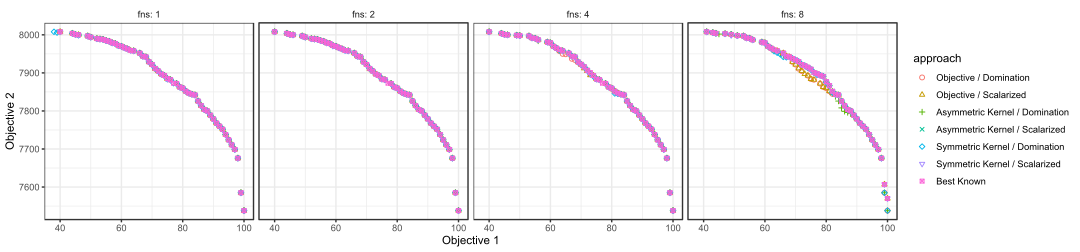

In [25]:
%%R -i preferred_ordering_front -i problem_name -i fronts_df_f -w 15 -h 3.5

fronts_df_f$approach = factor(fronts_df_f$approach, levels=preferred_ordering_front)

plt <- ggplot(fronts_df_f,
              aes(
                  x=`objective0`,
                  y=`objective1`,
                  color=`approach`,
                  shape=`approach`),
              fill=NA,
              ) +
geom_point() +
scale_shape_manual(values=1:length(preferred_ordering_front)) +
labs(x = "Objective 1", y = "Objective 2") +
facet_grid(. ~ fns, label=label_both) +
theme_bw() +
theme(strip.background = element_rect(fill = NA, color=NA))

ggsave(paste(problem_name, "_final_front_best_l100.pdf", sep=""), device=cairo_pdf)

plt

# Tabulation

In [9]:
data_quantiles_hypervolume_last = data_quantiles_hypervolume[data_quantiles_hypervolume["#evaluations bin"] == data_quantiles_hypervolume["#evaluations bin"].max()]
data_quantiles_hypervolume_last = data_quantiles_hypervolume_last.drop(columns=["show point", "#evaluations bin", "Q_0.05(1 - HV)", "Q_0.5(1 - HV)", "Q_0.95(1 - HV)"])
data_quantiles_hypervolume_last

,approach,l,fns,0.05,0.5,0.95
99,Asymmetric Kernel / Domination,12,1,1.000000,1.000000,1.000000
199,Asymmetric Kernel / Domination,12,2,1.000000,1.000000,1.000000
299,Asymmetric Kernel / Domination,12,4,1.000000,1.000000,1.000000
399,Asymmetric Kernel / Domination,12,8,1.000000,1.000000,1.000000
499,Asymmetric Kernel / Domination,25,1,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
9199,Symmetric Kernel / Scalarized,50,8,0.999385,1.000000,1.000000
9299,Symmetric Kernel / Scalarized,100,1,0.999650,0.999722,0.999887
9399,Symmetric Kernel / Scalarized,100,2,0.999697,0.999722,0.999845
9499,Symmetric Kernel / Scalarized,100,4,0.996743,0.998155,0.999585


In [11]:
%%R -i data_quantiles_hypervolume_last
tab <- data_quantiles_hypervolume_last %>%
    # mutate(`hypervolume` = paste(`0.05`, "/", `0.5`, "/",`0.95`)) %>%
    # select(-c(`0.05`, `0.5`, `0.95`)) %>%
    pivot_wider(names_from = approach, values_from=c(`0.05`, `0.5`, `0.95`), names_sep= ".", names_glue = "{approach}_{.value}") %>%
    mutate(fns=paste("fns: ", fns)) %>%
    gt(groupname_col = "fns") %>%
    tab_header(title="Hypervolume at end: Best-of-Traps vs MaxCut") %>%
    fmt_integer(starts_with("evaluations")) %>%
    tab_spanner_delim('_')
    # data_color(starts_with("evaluations"), "white") %>%
    # data_color(starts_with("time (ms)"), "ghostwhite")

tab %>% gtsave("2021-12-23-paper_bot_maxcut_table_median.tex")
tab

# Statistical Significance
See Best-of-Traps vs Best-of-Traps for a more detailed explanation

In [13]:
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.
final_bin = data_resampled_hypervolume["#evaluations bin"].max()
final_hvs = data_resampled_hypervolume[(data_resampled_hypervolume["l"] == 100) & (data_resampled_hypervolume["#evaluations bin"] == final_bin)]
subsequences = final_hvs.groupby(["fns", "approach"])["hypervolume"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["hypervolume_x"], nan=np.inf),
        np.nan_to_num(df["hypervolume_y"], nan=np.inf),
        use_continuity = False, alternative="greater")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_styled.to_latex("./2021-12-23-paper_bot_vs_maxcut_significant.tex", hrules=True, convert_css=True)
test_p_styled


In [16]:
sig_counts = significant.stack().rename("sig").reset_index().groupby("approach_x")["sig"].sum().reset_index()
sig_counts["sig"] = sig_counts["sig"].transform(str) + " (" + sig_counts["sig"].rank(ascending=False, method="dense").astype(int).transform(str) + ")"
sig_counts

,approach_x,sig
0,Objective / Domination,0.0 (5)
1,Objective / Scalarized,7.0 (3)
2,Asymmetric Kernel / Domination,1.0 (4)
3,Asymmetric Kernel / Scalarized,10.0 (2)
4,Symmetric Kernel / Domination,7.0 (3)
5,Symmetric Kernel / Scalarized,17.0 (1)


In [18]:
def compute_aoc(df, x, y, x_min, x_max, y_min, y_max, normalize = True):
    # To visualize area-under-the-curve, see the following schematic:
    #         |       first sample
    # y-max - | |---| /        sample in between
    #         | |   ._______ /          last sample
    #         | |           ._________ /
    #         | |    AOC              .___
    # y-min - | |________________________|
    #         L_____________________________
    #           ^ x-min                   ^ x-max

    #           ^---^
    #               ^-------^
    #                       ^---------^
    #                                 ^---^

    dx = pd.concat([pd.Series([x_min]), df[x], pd.Series([x_max])]).diff().shift(-1)
    ys = np.maximum(0.0, pd.concat([pd.Series([y_max]), df[y], pd.Series([y_min])]) - y_min)
    if normalize:
        return ((dx * ys).fillna(0).sum() / ((x_max - x_min) * (y_max - y_min)))
    else:
        return ((dx * ys).fillna(0).sum())

# compute_aoc(pd.DataFrame({ 'x': [0.5], 'y': [0.5]}), "x", "y", 0, 1, 0, 1)
# 0.5 * 1 + 0.5 * 0.5 + ??? * 0 = 0.75

In [19]:
# AOC - Evaluations
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

subs = data_hypervolume[data_hypervolume["l"] == 100].copy()
subs["1 - hypervolume"] = 1 - subs["hypervolume"]

measure = subs.\
    groupby(columns_run).\
    apply(lambda df: compute_aoc(df, "#evaluations", "1 - hypervolume", 0, 100_000_000, 0, 1.0)).\
    rename("aoc").\
    reset_index()

subsequences = measure.groupby(["fns", "approach"])["aoc"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu
# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]
def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["aoc_x"], nan=np.inf),
        np.nan_to_num(df["aoc_y"], nan=np.inf),
        use_continuity = False, alternative="less")

pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")

# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df

pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop = True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"], "test p")

def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"
    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a

test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_styled.to_latex("./2021-12-23-paper_bot_vs_maxcut_oac_evaluations_significant.tex", hrules=True, convert_css=True)
test_p_styled

In [22]:
# AOC - time
a = 2 * 0.05 # 2 * as tests are correlated and corrected for count: one out of two tests is guaranteed to fail.

subs = data_hypervolume[data_hypervolume["l"] == 100].copy()
subs["1 - hypervolume"] = 1 - subs["hypervolume"]

time_max = subs["time (ms)"].max()

measure = subs.\
    groupby(columns_run).\
    apply(lambda df: compute_aoc(df, "time (ms)", "1 - hypervolume", 0, time_max, 0, 1.0)).\
    rename("aoc").\
    reset_index()

subsequences = measure.groupby(["fns", "approach"])["aoc"].apply(list).reset_index()
pd_ordering_type = pd.api.types.CategoricalDtype(categories=preferred_ordering, ordered=True)
subsequences["approach"] = subsequences["approach"].astype(pd_ordering_type)
pairs_df = pd.merge(subsequences, subsequences, on="fns")

from scipy.stats import mannwhitneyu

# Filter out same set of samples
pairs_df = pairs_df[pairs_df["approach_x"] != pairs_df['approach_y']]


def perform_test_on_pair(df):
    return mannwhitneyu(
        np.nan_to_num(df["aoc_x"], nan=np.inf),
        np.nan_to_num(df["aoc_y"], nan=np.inf),
        use_continuity=False, alternative="less")


pairs_df[["test statistic", "test p"]] = pairs_df.apply(perform_test_on_pair, axis=1).apply(pd.Series)
pairs_df.pivot(["fns", "approach_x"], "approach_y", "test p")


# Holm–Bonferroni
def perform_comparison(df):
    df = df.sort_values(["test p"])
    df["H0 accepted"] = (df["test p"] < a / (len(df) - np.arange(0, len(df)))).expanding().min()
    return df


pairs_df = pairs_df.groupby("fns").apply(perform_comparison).reset_index(drop=True)
# Bonferroni (does the better correction actually impact the result?)
# pairs_df = pairs_df.sort_values("test p")
# pairs_df["H0 accepted"] = pairs_df["test p"] < a / len(pairs_df)
significant = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"],
                                                                              "H0 accepted")
test_p = pairs_df.sort_values(["fns", "approach_x", "approach_y"]).pivot(["fns", "approach_x"], ["approach_y"],
                                                                         "test p")


def styled(df):
    def get_style(m):
        if m is np.nan:
            return f"background-color: #d3d3d3; color: #000000;"
        if m:
            return f"background-color: #ffffff; color: #000000;"
        else:
            return f"background-color: #808080; color: #ffffff;"

    map_a = significant.applymap(get_style)
    map_a[np.isnan(df)] = f"background-color: #d3d3d3; color: #000000;"

    return map_a


test_p_styled = test_p.style.apply(styled, axis=None).format(na_rep="-", precision=3)
test_p_styled.to_latex("./2021-12-23-paper_bot_vs_maxcut_oac_time_significant.tex", hrules=True, convert_css=True)
test_p_styled